## Celldetection

This notebook uses the following pretrained model:
@article{UPSCHULTE2022102371,
    title = {Contour proposal networks for biomedical instance segmentation},
    journal = {Medical Image Analysis},
    volume = {77},
    pages = {102371},
    year = {2022},
    issn = {1361-8415},
    doi = {https://doi.org/10.1016/j.media.2022.102371},
    url = {https://www.sciencedirect.com/science/article/pii/S136184152200024X},
    author = {Eric Upschulte and Stefan Harmeling and Katrin Amunts and Timo Dickscheid},
    keywords = {Cell detection, Cell segmentation, Object detection, CPN},
}

In [3]:
import celldetection as cd
import torch, cv2, celldetection as cd
from skimage.data import coins
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2

### Helper functions to load the images

In [ ]:
def load_image(image_path):
    image = sitk.ReadImage(str(image_path))
    image = sitk.GetArrayFromImage(image)
    image[image<0] = 0
    image = image.T
    #image = np.flip(image,axis=1)
    #image = np.flip(image,axis=2)
    image = np.squeeze(image)
    return image

def preprocess(img: np.ndarray, min_val: float = None, max_val: float = 400) -> np.ndarray:
    """
    FOR VISUALIZATION PURPOSES
    Preprocesses volume data. Clips maximum value at max_val and then normalizes volume
    between 0-255.
    """
    data = img.copy()
    data[data > max_val] = max_val
    if min_val:
        data[data < min_val] = min_val
        #adjust alpha and beta values to change contrast and brightness
    data = cv2.normalize(src=data, dst=None, alpha=0.10, beta=255, 
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    return data



### Convert the image into smaller subsections for cell detection

Also converts to png

In [ ]:

img_path = "/Users/PriyaVelu/Documents/aaa_Research/Medical-Image-processing/Data/B0039/230628_B0039_PG_U01_280-0124_1_0.tif"

img = load_image(img_path)
img = preprocess(img)

plt.imshow(img)
plt.show()

#img = img[2] #do this if the image has multiple channels and you want to work with only one channel
height, width = img.shape #,channels

img2 = img.copy()
# Number of pieces Horizontally 
W_SIZE  = 10 
# Number of pieces Vertically to each Horizontal  
H_SIZE = 10

for ih in range(H_SIZE ):
   for iw in range(W_SIZE ):
   
      x = width/W_SIZE * iw 
      y = height/H_SIZE * ih
      h = (height / H_SIZE)
      w = (width / W_SIZE )
      print(x,y,h,w)
      img = img[int(y):int(y+h), int(x):int(x+w)]
      cv2.imwrite("/Users/PriyaVelu/Documents/aaa_Research/Medical-Image-processing/Data/Split-images/B0039-124/" + str(ih)+str(iw) +  ".png",img)
      img = img2

### Running celldetection inference

The model is also hosted in huggingface. Access it here: https://huggingface.co/spaces/ericup/celldetection


uint8 (1057, 1519, 3) (1, 255)


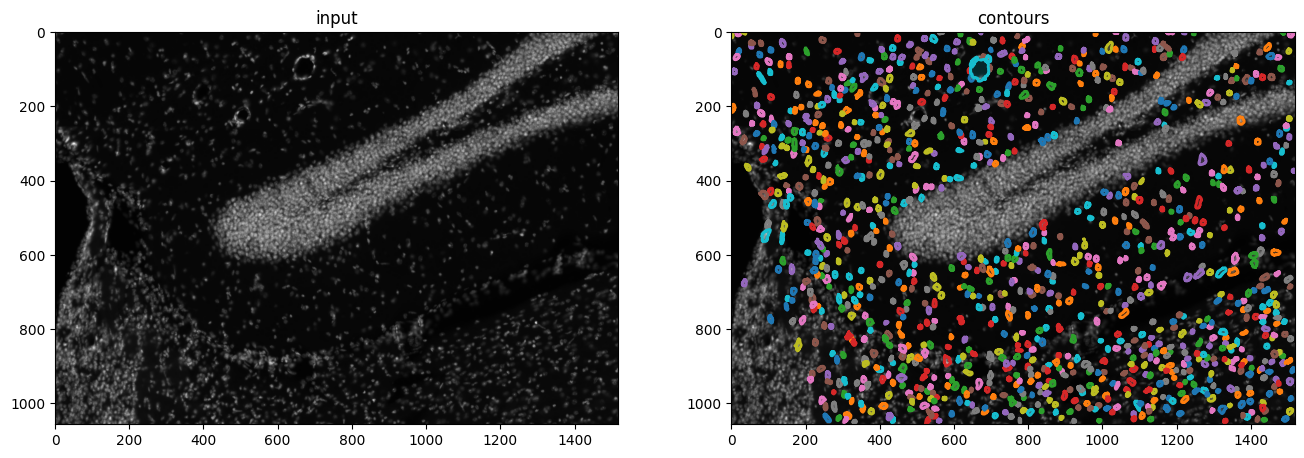

In [6]:
# Load pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = cd.fetch_model('ginoro_CpnResNeXt101UNet-fbe875f1a3e5ce2c', check_hash=True).to(device)
model.eval()

# Load input
img = cv2.imread('/Users/PriyaVelu/Documents/aaa_Research/Medical-Image-processing/Data/Split-images/D5L9/35.png',cv2.IMREAD_GRAYSCALE) #coins()
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
print(img.dtype, img.shape, (img.min(), img.max()))

# Run model
with torch.no_grad():
    x = cd.to_tensor(img, transpose=True, device=device, dtype=torch.float32)
    x = x / 255  # ensure 0..1 range
    x = x[None]  # add batch dimension: Tensor[3, h, w] -> Tensor[1, 3, h, w]
    y = model(x)

# Show results for each batch item
contours = y['contours']
for n in range(len(x)):
    cd.imshow_row(x[n], x[n], figsize=(16, 9), titles=('input', 'contours'))
    cd.plot_contours(contours[n])
    plt.show()

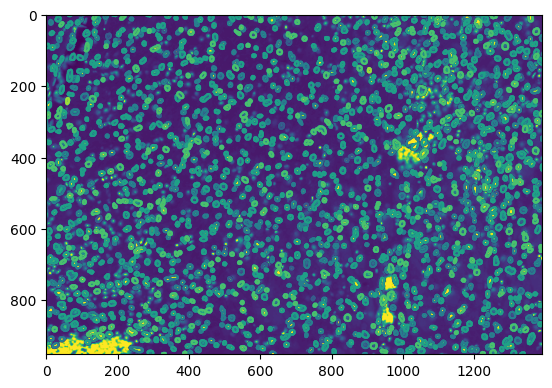

In [12]:
# overlay contours on original image

orig_img = cv2.imread('/Users/PriyaVelu/Downloads/image (1).png',cv2.IMREAD_GRAYSCALE)
segmented_img = cv2.imread('/Users/PriyaVelu/Downloads/image (2).png',cv2.IMREAD_GRAYSCALE)
plt.imshow(orig_img)
plt.contour(segmented_img)
plt.show()